In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import sparse 
import matplotlib.pyplot as plt
import torch

In [2]:
import sys; sys.path.append("/home/shhsu/download/scClass")
import scClass
from scClass.main import Model

## Matrix Preparation

In [3]:
# PBMC data preparation
adata = sc.datasets.pbmc3k()
adata_processed = sc.datasets.pbmc3k_processed()
adata_filter = adata[np.isin(list(adata.obs_names),list(adata_processed.obs_names)),:]
adata_filter.obs["cell_type"]  = adata_processed.obs["louvain"]
adata_filter.X = adata_filter.X.tocsc()
adata_filter.X

Trying to set attribute `.obs` of view, copying.


<2638x32738 sparse matrix of type '<class 'numpy.float32'>'
	with 2242529 stored elements in Compressed Sparse Column format>

## Post Preparation

In [4]:
# get gene on model
gene = adata_filter.var["gene_ids"].values
adata_filter2 = scClass.transmodel(adata_filter,gene=gene,gene_ref='ensembl_ids')

/home/shhsu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


get gene seq...
0% 15% 30% 45% 61% 76% 91% 
Of 32738 genes in the input file, 27518 were found in the training set of 45468 genes.
mapping to model...
0% 

In [5]:
# Normalized
adata_filter3 = scClass.normalize_simple(adata_filter2)

## Classifier

In [6]:
model = scClass.load()

loading model from:  /home/shhsu/download/scClass/scClass/data/model_train_v2.pkl


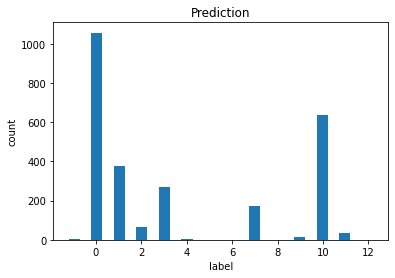

In [7]:
y_pred = scClass.predict_batch(adata_filter3,model)

In [8]:
scClass.save_predict(y_pred)

label stored in: './output/cell_type_20210913_130208.csv'


## Compare

In [9]:
trans_table = np.array([
['CD4 T cells',0],
['CD8 T cells',1],
['B cells',3],
['NK cells',7],
['Megakaryocytes',9],
['CD14+ Monocytes',10],
['FCGR3A+ Monocytes',10],
['Dendritic cells',11],
])

In [10]:
anno = adata_filter2.obs["cell_type"]
label = scClass.get_type_id(anno,trans_table)
label_y,label2 = np.unique(anno,return_inverse=True)

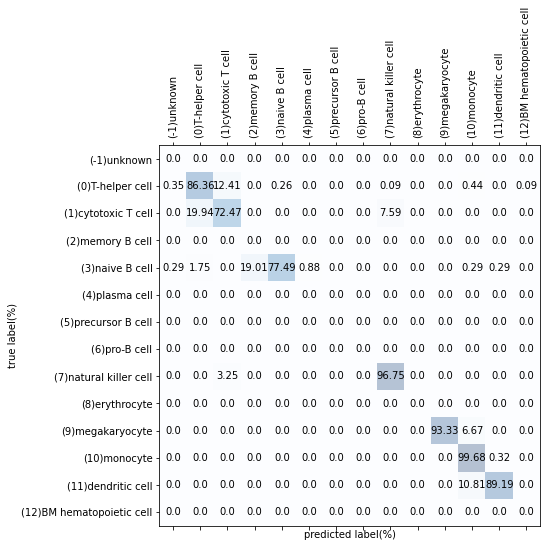

In [11]:
scClass.confusion_matrix(y_pred=y_pred,y_true=label)

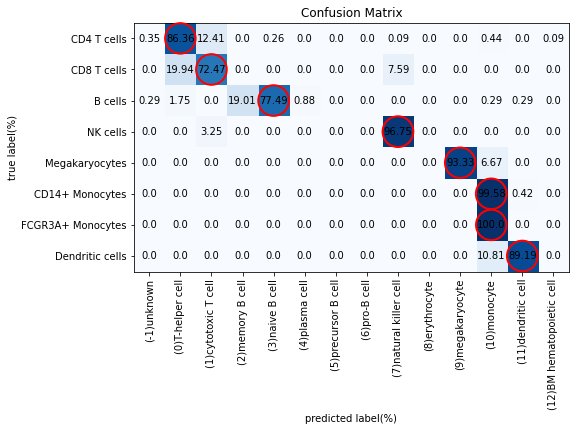

In [12]:
scClass.heatmap_matrix(y_pred=y_pred,y_true=label2,label_y=label_y,table=trans_table)

## Result